## 0.数据读取和处理

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import copy
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
import matplotlib.pylab as plt

import torch.nn as nn
import torch.optim as optim

#import torchvision.models as models

In [3]:
class DTSet(Dataset):
    
    def __init__(self, img_root, label_path, transform=None):
        self.img_root = img_root
        self.transform = transform
        self.labels = pd.read_excel(label_path, 
                                    true_values=["'High'", "'MIBC'"],
                                    false_values=["'Low'","'NMIBC'"])
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.img_root + "/" + self.labels.iloc[idx, 0].strip("'") + ".jpg"
        img = cv2.imread(img_path)
        img = Image.fromarray(img.astype('uint8')).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        grade = self.labels.iloc[idx, 1].astype(np.float)
        stage = self.labels.iloc[idx, 2].astype(np.float)
        
        sample = {'img':img, 'grade':grade, 'stage':stage}
        return sample


def show_sample(sample):
    """
        sample['img'].shape = (H, W, C)
    """
    title = "grade: " + str(sample['grade']) + " stage: " + str(sample['stage'])
    plt.figure()
    plt.imshow(sample['img'])
    plt.title(title)
    plt.axis('off')
    

def show_batch(batch):
    plt.figure()
    imgs = batch['img']
    print(imgs.shape)
    batch_size = len(imgs)
    grid = utils.make_grid(imgs)
    plt.imshow(grid.numpy().transpose(1,2,0))
    plt.axis('off')


#dataset = DTSet('data/TrainingData', 'data/DataInfo.xlsx')
#show_sample(dataset[0])
dataset = DTSet('/content/gdrive/My Drive/19-jsjsjds/data/TrainingData', 
                '/content/gdrive/My Drive/19-jsjsjds/data/DataInfo.xlsx', 
                transforms.Compose([
                    transforms.RandomAffine(10, translate=(0.05, 0.05), fillcolor=0),
                    #transforms.RandomHorizontalFlip(p=0.3),
                    #transforms.RandomVerticalFlip(p=0.3),
                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                    #transforms.Resize(224),
                    transforms.ToTensor()
                ]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1.模型定义

In [0]:
class Net(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.norm0 = nn.BatchNorm2d(3, eps=1e-08)
        
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(64, eps=1e-08)
        self.nonlinear1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, 8, stride=3) # 169
        self.norm2 = nn.BatchNorm2d(64, eps=1e-08)
        self.nonlinear2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 64, 5, stride=2) # 83
        self.norm3 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 64, 5, stride=2) # 40
        self.norm4 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(64, 64, 5) # 36
        self.norm5 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear5 = nn.ReLU()
        
        self.conv6 = nn.Conv2d(64, 64, 5) # 32
        self.norm6 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear6 = nn.ReLU()
        
        self.conv7 = nn.Conv2d(64, 64, 32) # 64, 1, 1
        self.norm7 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear7 = nn.ReLU()
        
        self.fc1 = nn.Linear(64, 500)
        self.norm8 = nn.BatchNorm1d(500, eps=1e-8)
        self.nonlinear8 = nn.ReLU()
        
        self.fc2 = nn.Linear(500, 400)
        self.norm9 = nn.BatchNorm1d(400, eps=1e-8)
        self.nonlinear9 = nn.ReLU()
        
        self.fc3 = nn.Linear(400, 300)
        self.normX = nn.BatchNorm1d(300, eps=1e-8)
        self.nonlinearX = nn.ReLU()
        
        self.fc4 = nn.Linear(300, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.norm0(x)
        out = self.nonlinear1(self.norm1(self.conv1(out)))
        out = self.nonlinear2(self.norm2(self.conv2(out)))
        out = self.nonlinear3(self.norm3(self.conv3(out)))
        out = self.nonlinear4(self.norm4(self.conv4(out)))
        out = self.nonlinear5(self.norm5(self.conv5(out)))
        out = self.nonlinear6(self.norm6(self.conv6(out)))
        out = self.nonlinear7(self.norm7(self.conv7(out)))
        
        N = out.size(0)
        out = out.view(N, -1)
        
        out = self.nonlinear8(self.norm8(self.fc1(out)))
        out = self.nonlinear9(self.norm9(self.fc2(out)))
        out = self.nonlinearX(self.normX(self.fc3(out)))
        out = self.fc4(out).view(-1).double()
        return out

### 1.1.Sanity check

In [5]:
epochs = 20

shuffle_mask = np.arange(len(dataset))
np.random.shuffle(shuffle_mask)
trainset = Subset(dataset, shuffle_mask[:20])    
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

for target_type in ['grade', 'stage']:
    torch.cuda.empty_cache()
    model = Net()
    model.zero_grad()
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-8)
    criterion = nn.BCEWithLogitsLoss()
    
    print("Sanity check for ", target_type)
    for epoch in range(epochs):
        train_acc = 0.0
        train_loss = 0.0
        model.train()
        for samples in train_loader:
            imgs = samples['img'].to(device)
            gt = samples[target_type].to(device)
            optimizer.zero_grad()

            scores = model(imgs)
            scores = scores.view(-1).double()
            loss = criterion(scores, gt) #criterion
            loss.backward()
            optimizer.step()

            scores[scores>0] = 1
            scores[scores<=0] = 0

            train_acc += (scores==gt).sum().cpu().numpy()
            train_loss += loss.item()*imgs.size(0)
        train_acc /= len(trainset)
        train_loss /= len(trainset)

        print("epoch %d / %d: acc %.4f loss %.4f" 
              %(epoch, epochs-1, train_acc, train_loss))
    print()

Sanity check for  grade
epoch 0 / 19: acc 0.5000 loss 0.7217
epoch 1 / 19: acc 0.5500 loss 0.6659
epoch 2 / 19: acc 0.6500 loss 0.6222
epoch 3 / 19: acc 0.7000 loss 0.6086
epoch 4 / 19: acc 0.9000 loss 0.4678
epoch 5 / 19: acc 0.7000 loss 0.5181
epoch 6 / 19: acc 0.9000 loss 0.3863
epoch 7 / 19: acc 1.0000 loss 0.3032
epoch 8 / 19: acc 0.9000 loss 0.3366
epoch 9 / 19: acc 0.9000 loss 0.2898
epoch 10 / 19: acc 1.0000 loss 0.2161
epoch 11 / 19: acc 1.0000 loss 0.1818
epoch 12 / 19: acc 1.0000 loss 0.1714
epoch 13 / 19: acc 0.9500 loss 0.2084
epoch 14 / 19: acc 1.0000 loss 0.1611
epoch 15 / 19: acc 1.0000 loss 0.1193
epoch 16 / 19: acc 1.0000 loss 0.1054
epoch 17 / 19: acc 1.0000 loss 0.1020
epoch 18 / 19: acc 1.0000 loss 0.1068
epoch 19 / 19: acc 0.9000 loss 0.2597

Sanity check for  stage
epoch 0 / 19: acc 0.4000 loss 0.7149
epoch 1 / 19: acc 0.4500 loss 0.6768
epoch 2 / 19: acc 0.9000 loss 0.5555
epoch 3 / 19: acc 0.8000 loss 0.4930
epoch 4 / 19: acc 0.9500 loss 0.3833
epoch 5 / 19: ac

## 2.训练

In [0]:
criterion = nn.BCEWithLogitsLoss()

def train(model, optimizer, epochs, target_type, verbose=True):
    """
        outside variable: device, criterion, train_loader,
                          val_loader trainset, valset
    """
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_model=copy.deepcopy(model.state_dict())
    best_train_acc, best_val_acc = 0, 0
    best_train_loss, best_val_loss  = np.inf, np.inf
    
    model.to(device) # device
    for epoch in range(epochs):
        train_acc = 0.0
        train_loss = 0.0
        model.train()
        for samples in train_loader:
            imgs = samples['img'].to(device)
            gt = samples[target_type].to(device)
            
            scores = model(imgs)
            scores = scores.view(-1).double()
            loss = criterion(scores, gt) #criterion
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            scores[scores>0] = 1
            scores[scores<=0] = 0

            train_acc += (scores==gt).sum().cpu().numpy()
            train_loss += loss.item()*imgs.size(0)
        train_acc /= len(trainset)
        train_loss /= len(trainset)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        
        model.eval()
        val_acc, val_loss = 0.0, 0.0
        with torch.no_grad():
            for samples in val_loader:
                imgs = samples['img'].to(device)
                gt = samples[target_type].to(device)
                
                scores = model(imgs)
                scores = scores.view(-1).double()
                loss = criterion(scores, gt)
                scores[scores>0] = 1
                scores[scores<=0] = 0
                
                val_acc += (scores == gt).sum().cpu().numpy()
                val_loss += loss.item()*imgs.size(0)
        
            val_acc /= len(valset)
            val_loss /= len(valset)
            history['val_acc'].append(val_acc)
            history['val_loss'].append(val_loss)
            
        if val_acc >= best_val_acc and val_loss < best_val_loss:
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_train_loss, best_val_loss = train_loss, val_loss
            best_model = copy.deepcopy(model.state_dict())
        
        if verbose:
            print("Epoch %d / %d train_loss %.4f train_acc %.4f val_loss %.4f val_acc %.4f"
                 %(epoch, epochs-1, train_loss, train_acc, val_loss, val_acc))
    if verbose:
        plt.figure()
        plt.plot(history['train_loss'])
        plt.plot(history['val_loss'])
        plt.title('training loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training', 'validation'], loc='upper left')
        
        plt.figure()
        plt.plot(history['train_acc'])
        plt.plot(history['val_acc'])
        plt.title('training accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['training', 'validation'], loc='upper left')
        plt.show()
    
    print("best training acc %.4f best training loss %.4f best val acc %.4f best val loss %.4f"
         %(best_train_acc, best_train_loss, best_val_acc, best_val_loss))
    model.load_state_dict(best_model)
    return model
  

def predict(model, target_type):
    acc, loss = 0.0, 0.0
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
    model.eval()
    with torch.no_grad():
        for samples in loader:
            imgs = samples['img'].to(device)
            gt = samples[target_type].to(device)
                
            scores = model(imgs)
            scores = scores.view(-1).double()
            loss = criterion(scores, gt)
            scores[scores>0] = 1
            scores[scores<=0] = 0
               
            acc += (scores == gt).sum().cpu().numpy()
            loss += loss.item()*imgs.size(0)
            
        acc = acc/len(dataset)
        loss /= len(dataset)
        print("total accuracy %.4f total loss %.4f" % (acc, loss))
        
        if acc>0.9:
            root = '/content/gdrive/My Drive/19-jsjsjds/'
            fname = target_type+'_acc_'+str(acc)+'_loss_'+str(float(loss))+'.pth'
            torch.save(model.state_dict(), root+fname)

### 2.1.Grade预测模型训练

Epoch 0 / 49 train_loss 0.5792 train_acc 0.6950 val_loss 0.6905 val_acc 0.5256
Epoch 1 / 49 train_loss 0.2874 train_acc 0.9150 val_loss 0.9043 val_acc 0.5513
Epoch 2 / 49 train_loss 0.2017 train_acc 0.9525 val_loss 0.2516 val_acc 0.9359
Epoch 3 / 49 train_loss 0.1845 train_acc 0.9425 val_loss 0.5495 val_acc 0.7179
Epoch 4 / 49 train_loss 0.1314 train_acc 0.9575 val_loss 0.1116 val_acc 0.9872
Epoch 5 / 49 train_loss 0.1304 train_acc 0.9550 val_loss 0.0846 val_acc 0.9872
Epoch 6 / 49 train_loss 0.1063 train_acc 0.9675 val_loss 0.0495 val_acc 1.0000
Epoch 7 / 49 train_loss 0.0631 train_acc 0.9850 val_loss 0.0475 val_acc 0.9872
Epoch 8 / 49 train_loss 0.1002 train_acc 0.9725 val_loss 0.0915 val_acc 0.9615
Epoch 9 / 49 train_loss 0.0668 train_acc 0.9775 val_loss 0.6161 val_acc 0.7564
Epoch 10 / 49 train_loss 0.0824 train_acc 0.9800 val_loss 0.1297 val_acc 0.9615
Epoch 11 / 49 train_loss 0.0670 train_acc 0.9750 val_loss 0.1733 val_acc 0.9103
Epoch 12 / 49 train_loss 0.0528 train_acc 0.9900 v

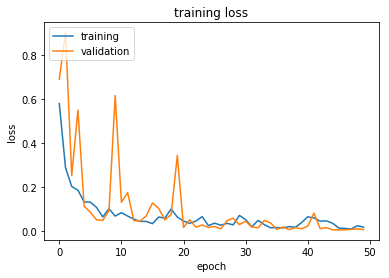

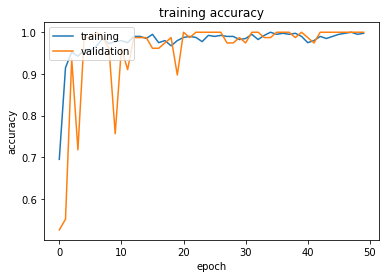

best training acc 0.9950 best training loss 0.0123 best val acc 1.0000 best val loss 0.0038
total accuracy 1.0000 total loss 0.0003


In [7]:
torch.cuda.empty_cache()
target_type = 'grade'

grade_predictor = Net()
#model_path = '/content/gdrive/My Drive/19-jsjsjds/grade_predictor.pth'
#grade_predictor.load_state_dict(torch.load(model_path))
grade_predictor.zero_grad()

optimizer = optim.Adam(grade_predictor.parameters(), lr=0.0005, eps=1e-8)

shuffle_mask = np.arange(len(dataset))
np.random.shuffle(shuffle_mask)
trainset = Subset(dataset, shuffle_mask[:400])
valset = Subset(dataset, shuffle_mask[400:])

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

grade_predictor = train(grade_predictor, optimizer, 50, target_type, verbose=True)

predict(grade_predictor, 'grade')

### 2.2.Stage预测模型（迁移）训练

Epoch 0 / 29 train_loss 1.9160 train_acc 0.6300 val_loss 1.5631 val_acc 0.6154
Epoch 1 / 29 train_loss 0.6820 train_acc 0.7800 val_loss 0.4664 val_acc 0.7564
Epoch 2 / 29 train_loss 0.3674 train_acc 0.8700 val_loss 0.3749 val_acc 0.8205
Epoch 3 / 29 train_loss 0.2493 train_acc 0.8800 val_loss 0.2540 val_acc 0.8718
Epoch 4 / 29 train_loss 0.1713 train_acc 0.9300 val_loss 0.2561 val_acc 0.8718
Epoch 5 / 29 train_loss 0.1611 train_acc 0.9375 val_loss 0.2124 val_acc 0.9487
Epoch 6 / 29 train_loss 0.1453 train_acc 0.9650 val_loss 0.1916 val_acc 0.9103
Epoch 7 / 29 train_loss 0.0609 train_acc 0.9825 val_loss 0.1124 val_acc 0.9359
Epoch 8 / 29 train_loss 0.0495 train_acc 0.9850 val_loss 0.1286 val_acc 0.9615
Epoch 9 / 29 train_loss 0.0297 train_acc 0.9925 val_loss 0.0663 val_acc 0.9744
Epoch 10 / 29 train_loss 0.1059 train_acc 0.9700 val_loss 0.1094 val_acc 0.9615
Epoch 11 / 29 train_loss 0.0388 train_acc 0.9925 val_loss 0.1441 val_acc 0.9615
Epoch 12 / 29 train_loss 0.0415 train_acc 0.9850 v

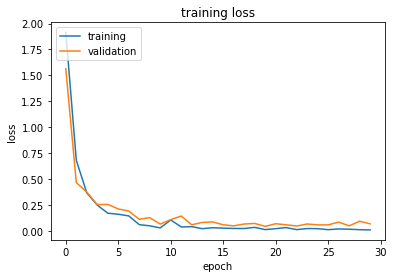

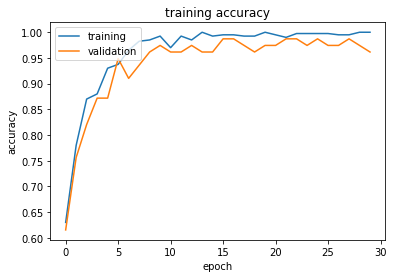

best training acc 0.9975 best training loss 0.0128 best val acc 0.9872 best val loss 0.0477
total accuracy 0.9958 total loss 0.0010


In [8]:
target_type = 'stage'
torch.cuda.empty_cache()

stage_predictor = Net()
if grade_predictor is not None:
    stage_predictor.load_state_dict(grade_predictor.state_dict()) # transfer

optimizer = optim.Adam(stage_predictor.parameters(), lr=0.0001, eps=1e-8)

shuffle_mask = np.arange(len(dataset))
np.random.shuffle(shuffle_mask)
trainset = Subset(dataset, shuffle_mask[:400])
valset = Subset(dataset, shuffle_mask[400:])    
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

stage_predictor = train(stage_predictor, optimizer, 30, 'stage', verbose=True)

predict(stage_predictor, target_type)

### 2.3.Stage预测模型（非迁移）训练

Epoch 0 / 29 train_loss 0.6844 train_acc 0.5375 val_loss 0.6925 val_acc 0.5897
Epoch 1 / 29 train_loss 0.5970 train_acc 0.7625 val_loss 0.6990 val_acc 0.4103
Epoch 2 / 29 train_loss 0.4807 train_acc 0.8650 val_loss 0.6435 val_acc 0.5769
Epoch 3 / 29 train_loss 0.3592 train_acc 0.9450 val_loss 0.3219 val_acc 0.9359
Epoch 4 / 29 train_loss 0.2814 train_acc 0.9600 val_loss 0.2445 val_acc 0.9615
Epoch 5 / 29 train_loss 0.2249 train_acc 0.9775 val_loss 0.1873 val_acc 0.9615
Epoch 6 / 29 train_loss 0.1958 train_acc 0.9800 val_loss 0.1829 val_acc 0.9744
Epoch 7 / 29 train_loss 0.1817 train_acc 0.9850 val_loss 0.1693 val_acc 0.9744
Epoch 8 / 29 train_loss 0.1447 train_acc 0.9950 val_loss 0.1811 val_acc 0.9615
Epoch 9 / 29 train_loss 0.1361 train_acc 0.9950 val_loss 0.1599 val_acc 0.9744
Epoch 10 / 29 train_loss 0.1246 train_acc 1.0000 val_loss 0.1556 val_acc 0.9615
Epoch 11 / 29 train_loss 0.1121 train_acc 0.9975 val_loss 0.1345 val_acc 0.9872
Epoch 12 / 29 train_loss 0.1133 train_acc 0.9975 v

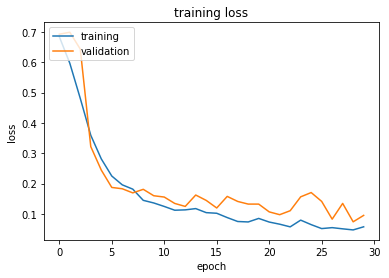

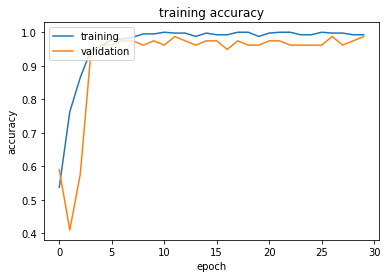

best training acc 0.9975 best training loss 0.0547 best val acc 0.9872 best val loss 0.0827
total accuracy 0.9937 total loss 0.0025


In [9]:
target_type = 'stage'
torch.cuda.empty_cache()

stage_predictor = Net()

optimizer = optim.Adam(stage_predictor.parameters(), lr=0.0001, eps=1e-8)

stage_predictor = train(stage_predictor, optimizer, 30, 'stage', verbose=True)

predict(stage_predictor, target_type)